In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.base.model
import statsmodels.tsa.api as smt
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import r2_score, roc_auc_score, roc_curve
import ml_metrics as metrics
from itertools import product
from tqdm import tqdm

In [3]:
def show_plot(df):
    plt.figure(figsize = (12, 7))
    layout = (2, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))

    df.plot(ax = ts_ax)
    smt.graphics.plot_acf(df, lags = 30, ax = acf_ax, alpha = 0.5)
    smt.graphics.plot_pacf(df, lags = 30, ax = pacf_ax, alpha = 0.5)

    plt.tight_layout()

In [26]:
def decomposition(df, model):
    plt.figure(figsize = (12, 7))
    r = statsmodels.tsa.seasonal.seasonal_decompose(df['Value'], model=model) 
    plt.plot(r.seasonal, c = 'red', label = 'Seasonal component')
    plt.plot(r.trend, label = 'Trend')
    plt.plot(r.resid, c = 'grey', label = 'Lags')
    plt.legend(loc = 'upper left')    

In [140]:
df = pd.read_csv('training.csv', ",", parse_dates=['Date'], dayfirst=True)
df.reset_index(inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')
df.tail()

,index,Value
Date,,
1988-08-01,355,63.8851
1988-09-01,356,63.7040
1988-10-01,357,64.0220
1988-11-01,358,64.1173
1988-12-01,359,64.4210


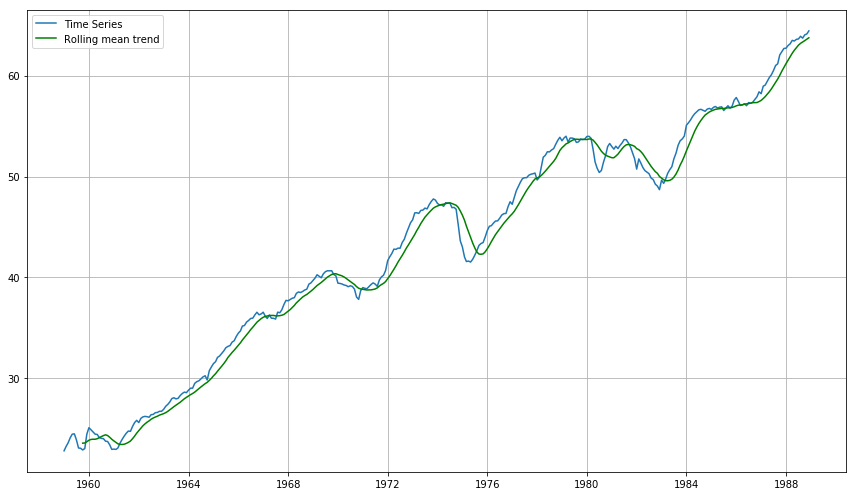

In [141]:
plt.figure(figsize=(12,7))
plt.plot(df['Value'], label = "Time Series")
##
rolling_mean = df['Value'].rolling(window=10).mean()

plt.plot(rolling_mean, "g", label="Rolling mean trend")
plt.legend(loc="upper left")


plt.grid(True)
plt.tight_layout()


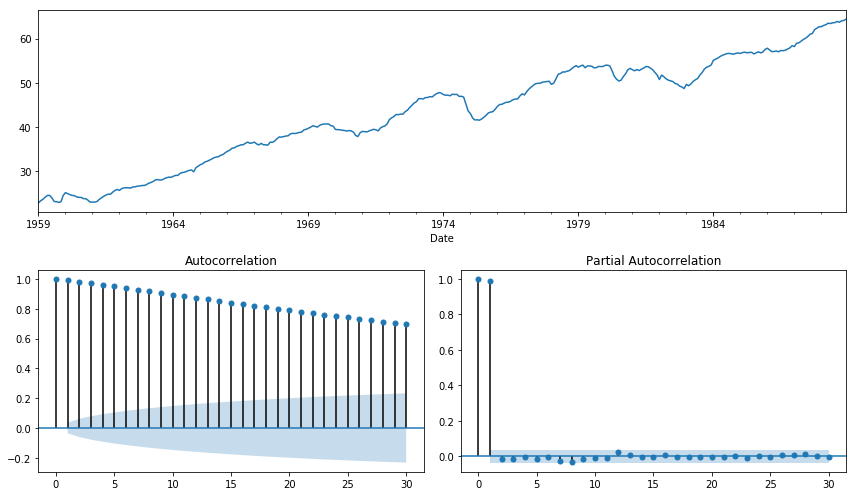

In [142]:
show_plot(df['Value'])

## Аддитивная модель

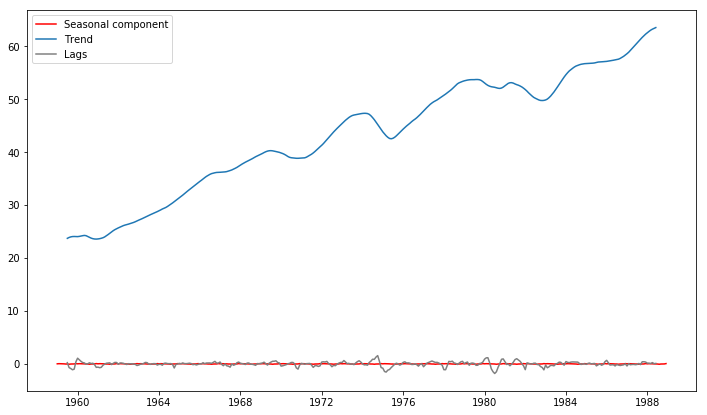

In [143]:
decomposition(df, 'additive')

## Мультипликативная модель

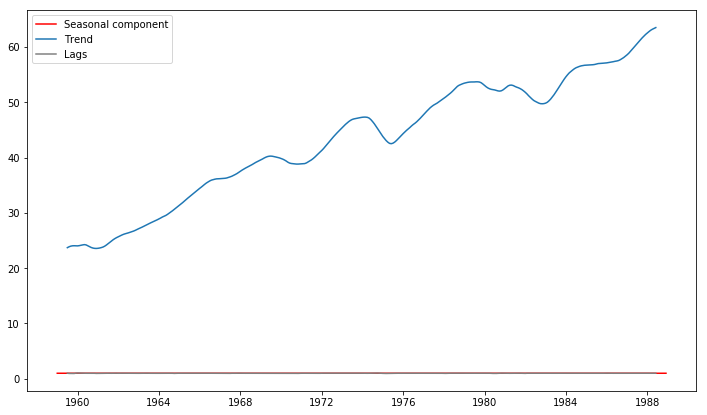

In [144]:
decomposition(df, 'multiplicative')

Заметим, что в мультипликативной модели меньше разброс ошибок

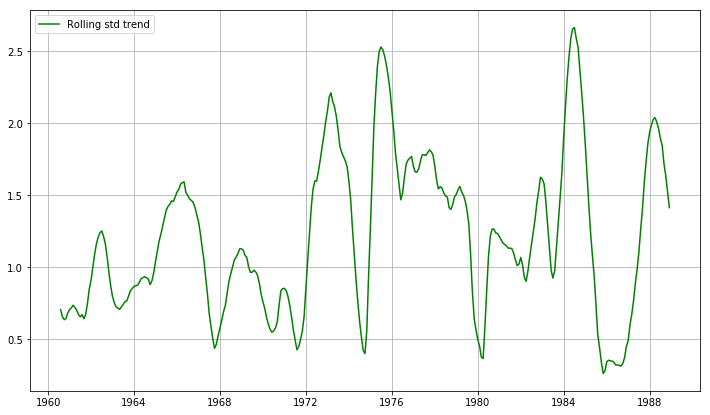

In [145]:
plt.figure(figsize = (12, 7))
rolling_std = df['Value'].rolling(window=20).std()
plt.plot( rolling_std, "g", label="Rolling std trend")
plt.legend(loc="upper left")
plt.grid(True)

In [146]:
df['Value'] = df['Value'].dropna()
test = sm.tsa.adfuller(df['Value'])
print ( 'adf: ', test[0])
print ('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print ('есть единичные корни, ряд не стационарен')
else:
    print ('единичных корней нет, ряд стационарен')

adf:  -0.253391179928
p-value:  0.931851042299
Critical values:  {'1%': -3.4489583388155194, '5%': -2.869739378430086, '10%': -2.5711381780459002}
есть единичные корни, ряд не стационарен


In [147]:
df1 = df['Value'].diff(periods=1).dropna()
df1.head()

Date
1959-02-01    0.4471
1959-03-01    0.3354
1959-04-01    0.5030
1959-05-01    0.3634
1959-06-01    0.0279
Name: Value, dtype: float64

In [148]:
test = sm.tsa.adfuller(df1)
print ( 'adf: ', test[0])
print ('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print ('есть единичные корни, ряд не стационарен')
else:
    print ('единичных корней нет, ряд стационарен')

adf:  -7.36731149521
p-value:  9.1641495611e-11
Critical values:  {'1%': -3.4489583388155194, '5%': -2.869739378430086, '10%': -2.5711381780459002}
единичных корней нет, ряд стационарен


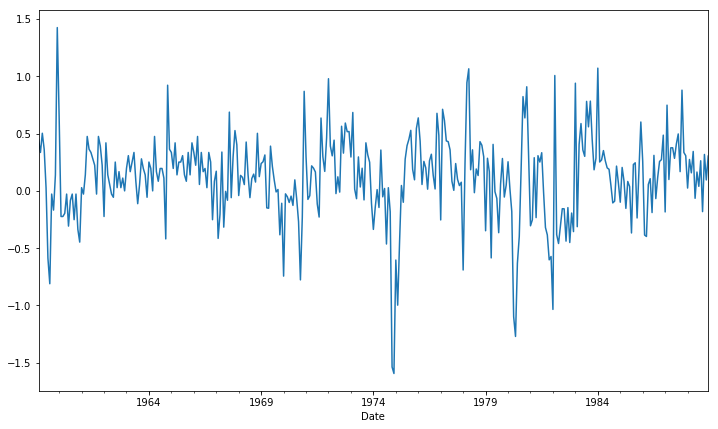

In [149]:
%matplotlib inline
plt.figure(figsize = (12, 7))
plt.grid(True)
df1.plot() #интегрированный ряд первого порядка

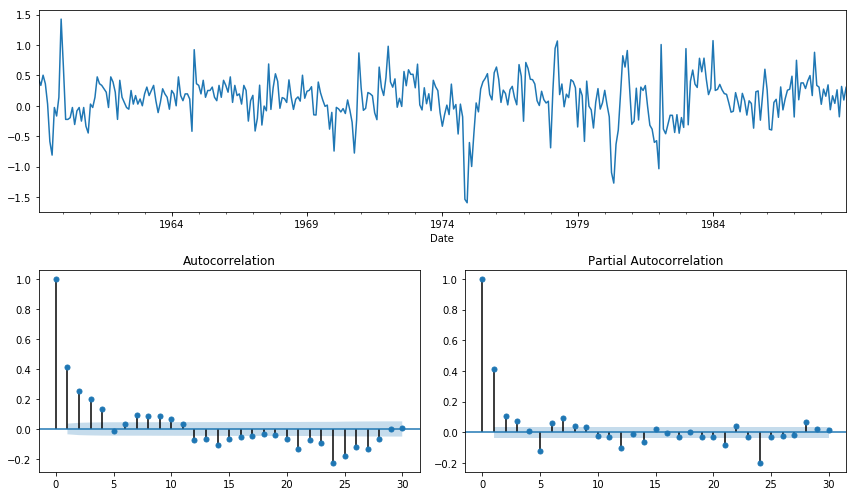

In [150]:
show_plot(df1) #интегрированный ряд первого порядка, его автокореляция и частичная автокорелляция

In [151]:
X = df.Value
train, test = X[0:-30], X[329:]
#history = [x for x in train]
#testing = [x for x in test]
#model = smt.statespace.SARIMAX(history, order=(1,1,1)).fit()
#print(model.summary())

In [175]:
ps = range(0, 5)
qs = range(0, 4)
tr = range(0, 2)

param_trend = product(tr, tr, tr, tr)
param_trend_list = list(param_trend)

parameters = product(ps, qs)
parameters_list = list(parameters)
#len(parameters_list)

predictions = list()
#results = []
best_aic = float("inf")

for p in tqdm(param_trend_list):
    for param in tqdm(parameters_list):
        #try except нужен, потому что на некоторых наборах параметров модель не обучается
        try:
            model = sm.tsa.SARIMAX(train, order=(param[0],1,param[1]), trend = [p[0], p[1], p[2], p[3]], freq='W' ).fit()
            #model=sm.tsa.ARIMA(train, order=(param[0], 1, param[1]), freq='W').fit()
        #выводим параметры, на которых модель не обучается и переходим к следующему набору
        except ValueError:
            print('wrong parameters:', param)
            continue
        aic = model.aic
        #сохраняем лучшую модель, aic, параметры
        if aic < best_aic:
            best_p = p
            best_model = model
            best_aic = aic
            best_param = param
        #results.append([param, model.aic])



  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 10%|█         | 2/20 [00:00<00:01, 15.39it/s]

wrong parameters: (0, 0)




 15%|█▌        | 3/20 [00:00<00:01, 10.76it/s]

 20%|██        | 4/20 [00:00<00:01,  8.30it/s]

 30%|███       | 6/20 [00:00<00:01,  8.74it/s]

 35%|███▌      | 7/20 [00:00<00:01,  8.50it/s]

 40%|████      | 8/20 [00:01<00:01,  7.97it/s]

 45%|████▌     | 9/20 [00:01<00:01,  8.08it/s]

wrong parameters: (2, 1)




 55%|█████▌    | 11/20 [00:01<00:01,  8.20it/s]

 60%|██████    | 12/20 [00:01<00:01,  6.90it/s]

 65%|██████▌   | 13/20 [00:01<00:01,  6.79it/s]

 70%|███████   | 14/20 [00:02<00:00,  6.54it/s]/home/anna/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/tools.py:405: RuntimeWarning: invalid value encountered in sqrt
  x = r / ((1 - r**2)**0.5)


 75%|███████▌  | 15/20 [00:02<00:00,  6.61it/s]

 80%|████████  | 16/20 [00:03<00:00,  5.04it/s]

 85%|████████▌ | 17/20 [00:03<00:00,  5.10it/s]

 90%|█████████ | 18/20 [00:03<00:00,  4.89it/s]

wrong parameters: (4, 2)




100%|██████████| 20/20 [00:04<00:00,  4.81it/s]


  6%|▋         | 1/16 [00:04<01:02,  4.16s/it]

  0%|          | 0/20 [00:00<?, ?it/s]/home/anna/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


 10%|█         | 2/20 [00:00<00:01, 10.75it/s]

wrong parameters: (0, 0)


/home/anna/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


 15%|█▌        | 3/20 [00:00<00:02,  6.72it/s]/home/anna/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


 20%|██        | 4/20 [00:00<00:02,  5.79it/s]/home/anna/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


 25%|██▌       | 5/20 [00:00<00:02,  5.78it/s]/home/anna/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


 3

wrong parameters: (2, 1)



Exception in thread Thread-14:
Traceback (most recent call last):
  File "/home/anna/anaconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/anna/anaconda3/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/anna/anaconda3/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration


 55%|█████▌    | 11/20 [00:02<00:01,  5.29it/s]/home/anna/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)

 60%|██████    | 12/20 [00:02<00:01,  5.04it/s]/home/anna/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)

 65%|██████

wrong parameters: (4, 2)
wrong parameters: (0, 0)


/home/anna/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)

 10%|█         | 2/20 [00:00<00:01, 10.50it/s]/home/anna/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)

 15%|█▌        | 3/20 [00:00<00:02,  7.49it/s]/home/anna/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)

 20%|██        | 4/20 [00:00<00:02,  6.29it/s]/home/anna/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)

 25%|█

wrong parameters: (2, 1)


/home/anna/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)

 55%|█████▌    | 11/20 [00:03<00:02,  3.62it/s]/home/anna/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)

 60%|██████    | 12/20 [00:03<00:02,  3.33it/s]/home/anna/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)

 65%|██████▌   | 13/20 [00:04<00:02,  3.23it/s]/home/anna/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)

 70

wrong parameters: (4, 2)
wrong parameters: (0, 0)


/home/anna/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)

 10%|█         | 2/20 [00:00<00:02,  8.99it/s]/home/anna/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)

 15%|█▌        | 3/20 [00:00<00:02,  6.80it/s]/home/anna/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)

 20%|██        | 4/20 [00:00<00:02,  5.70it/s]/home/anna/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)

 25%|█

wrong parameters: (2, 1)


/home/anna/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)

 55%|█████▌    | 11/20 [00:02<00:01,  5.00it/s]/home/anna/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)

 60%|██████    | 12/20 [00:02<00:01,  4.80it/s]/home/anna/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)

 65%|██████▌   | 13/20 [00:02<00:01,  4.72it/s]/home/anna/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)

 70

wrong parameters: (3, 2)


/home/anna/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)

 80%|████████  | 16/20 [00:03<00:00,  4.75it/s]/home/anna/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)

 85%|████████▌ | 17/20 [00:03<00:00,  4.65it/s]/home/anna/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)

  0%|          | 0/20 [00:00<?, ?it/s]

wrong parameters: (4, 2)
wrong parameters: (0, 0)



 45%|████▌     | 9/20 [00:01<00:02,  5.25it/s]

wrong parameters: (2, 1)



 70%|███████   | 14/20 [00:02<00:01,  4.81it/s]

wrong parameters: (3, 2)



  0%|          | 0/20 [00:00<?, ?it/s]

wrong parameters: (4, 2)
wrong parameters: (0, 0)


/home/anna/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)

 10%|█         | 2/20 [00:00<00:01,  9.83it/s]/home/anna/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)

 15%|█▌        | 3/20 [00:00<00:02,  6.93it/s]/home/anna/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)

 20%|██        | 4/20 [00:00<00:02,  5.79it/s]/home/anna/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)

 25%|█

wrong parameters: (2, 1)


/home/anna/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)

 55%|█████▌    | 11/20 [00:02<00:01,  4.95it/s]/home/anna/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)

 60%|██████    | 12/20 [00:02<00:01,  4.74it/s]/home/anna/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)

 65%|██████▌   | 13/20 [00:02<00:01,  4.67it/s]/home/anna/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)

 70

wrong parameters: (3, 2)


/home/anna/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)

 80%|████████  | 16/20 [00:03<00:00,  4.70it/s]/home/anna/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)

 85%|████████▌ | 17/20 [00:03<00:00,  4.61it/s]/home/anna/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)

  0%|          | 0/20 [00:00<?, ?it/s]

wrong parameters: (4, 2)
wrong parameters: (0, 0)


/home/anna/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)

 10%|█         | 2/20 [00:00<00:01,  9.51it/s]/home/anna/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)

 15%|█▌        | 3/20 [00:00<00:02,  6.54it/s]/home/anna/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)

 20%|██        | 4/20 [00:00<00:02,  5.57it/s]/home/anna/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)

 25%|█

wrong parameters: (3, 2)


/home/anna/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)

 80%|████████  | 16/20 [00:05<00:01,  3.09it/s]/home/anna/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)

 85%|████████▌ | 17/20 [00:05<00:00,  3.09it/s]/home/anna/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)

  0%|          | 0/20 [00:00<?, ?it/s]

wrong parameters: (4, 2)
wrong parameters: (0, 0)


/home/anna/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)

 10%|█         | 2/20 [00:00<00:02,  8.55it/s]/home/anna/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)

 15%|█▌        | 3/20 [00:00<00:03,  5.36it/s]/home/anna/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)

 20%|██        | 4/20 [00:00<00:03,  4.17it/s]/home/anna/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)

 25%|█

wrong parameters: (3, 2)


/home/anna/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)

 80%|████████  | 16/20 [00:04<00:01,  3.70it/s]/home/anna/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)

 85%|████████▌ | 17/20 [00:04<00:00,  3.64it/s]/home/anna/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)

  0%|          | 0/20 [00:00<?, ?it/s]

wrong parameters: (4, 2)
wrong parameters: (0, 0)



 55%|█████▌    | 11/20 [00:02<00:01,  5.29it/s]/home/anna/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)

 70%|███████   | 14/20 [00:03<00:01,  4.43it/s]

wrong parameters: (3, 2)



  0%|          | 0/20 [00:00<?, ?it/s]

wrong parameters: (4, 2)
wrong parameters: (0, 0)


/home/anna/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)

 10%|█         | 2/20 [00:00<00:01,  9.94it/s]/home/anna/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)

 15%|█▌        | 3/20 [00:00<00:02,  7.05it/s]/home/anna/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)

 20%|██        | 4/20 [00:00<00:02,  5.90it/s]/home/anna/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)

 25%|█

wrong parameters: (3, 2)


/home/anna/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)

 80%|████████  | 16/20 [00:03<00:00,  4.44it/s]/home/anna/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)

 85%|████████▌ | 17/20 [00:03<00:00,  4.35it/s]/home/anna/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)

  0%|          | 0/20 [00:00<?, ?it/s]

wrong parameters: (4, 2)
wrong parameters: (0, 0)


/home/anna/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)

 10%|█         | 2/20 [00:00<00:01,  9.05it/s]/home/anna/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)

 15%|█▌        | 3/20 [00:00<00:02,  6.70it/s]/home/anna/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)

 20%|██        | 4/20 [00:00<00:02,  5.74it/s]/home/anna/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)

 25%|█

wrong parameters: (3, 2)


/home/anna/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)

 80%|████████  | 16/20 [00:04<00:01,  3.53it/s]/home/anna/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)

 85%|████████▌ | 17/20 [00:04<00:00,  3.52it/s]/home/anna/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)

  0%|          | 0/20 [00:00<?, ?it/s]

wrong parameters: (4, 2)
wrong parameters: (0, 0)


/home/anna/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)

 10%|█         | 2/20 [00:00<00:02,  8.68it/s]/home/anna/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)

 15%|█▌        | 3/20 [00:00<00:02,  6.25it/s]/home/anna/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)

 20%|██        | 4/20 [00:00<00:03,  5.23it/s]/home/anna/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)

 25%|█

wrong parameters: (3, 2)


/home/anna/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)

 80%|████████  | 16/20 [00:03<00:00,  4.04it/s]/home/anna/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)

 85%|████████▌ | 17/20 [00:04<00:00,  3.99it/s]/home/anna/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)

  0%|          | 0/20 [00:00<?, ?it/s]

wrong parameters: (4, 2)
wrong parameters: (0, 0)



 20%|██        | 4/20 [00:01<00:06,  2.44it/s]/home/anna/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)

 35%|███▌      | 7/20 [00:02<00:04,  2.96it/s]/home/anna/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)

 55%|█████▌    | 11/20 [00:03<00:03,  2.78it/s]/home/anna/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)

 70%|███████   | 14/20 [00:04<00:02,  2.84it/s]

wrong parameters: (3, 2)


/home/anna/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)

  0%|          | 0/20 [00:00<?, ?it/s]

wrong parameters: (4, 2)
wrong parameters: (0, 0)


/home/anna/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)

 10%|█         | 2/20 [00:00<00:02,  8.60it/s]/home/anna/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)

 15%|█▌        | 3/20 [00:00<00:02,  6.20it/s]/home/anna/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)

 20%|██        | 4/20 [00:00<00:03,  5.25it/s]/home/anna/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)

 25%|█

wrong parameters: (3, 2)


/home/anna/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)

 80%|████████  | 16/20 [00:04<00:01,  3.96it/s]/home/anna/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)

 85%|████████▌ | 17/20 [00:04<00:00,  3.81it/s]/home/anna/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)

  0%|          | 0/20 [00:00<?, ?it/s]

wrong parameters: (4, 2)
wrong parameters: (0, 0)


/home/anna/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)

 10%|█         | 2/20 [00:00<00:02,  6.97it/s]/home/anna/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)

 15%|█▌        | 3/20 [00:00<00:03,  5.24it/s]/home/anna/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)

 20%|██        | 4/20 [00:00<00:03,  4.45it/s]/home/anna/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)

 25%|█

wrong parameters: (3, 2)


/home/anna/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)

 80%|████████  | 16/20 [00:05<00:01,  2.97it/s]/home/anna/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)

 85%|████████▌ | 17/20 [00:05<00:01,  2.98it/s]/home/anna/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)

  0%|          | 0/20 [00:00<?, ?it/s]

wrong parameters: (4, 2)
wrong parameters: (0, 0)


/home/anna/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)

 10%|█         | 2/20 [00:00<00:02,  7.59it/s]/home/anna/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)

 15%|█▌        | 3/20 [00:00<00:03,  5.64it/s]/home/anna/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)

 20%|██        | 4/20 [00:00<00:03,  4.82it/s]/home/anna/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)

 25%|█

wrong parameters: (3, 2)


/home/anna/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)

 80%|████████  | 16/20 [00:04<00:01,  3.73it/s]/home/anna/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)

 85%|████████▌ | 17/20 [00:04<00:00,  3.67it/s]/home/anna/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)

100%|██████████| 16/16 [01:19<00:00,  4.99s/it]

wrong parameters: (4, 2)


In [176]:
print(best_aic, best_param, best_p)

237.605211502 (2, 3) (1, 0, 0, 0)


In [126]:



#df.index = pd.DatetimeIndex(end=pd.datetime.today(), periods=len(df), freq='1D')
model = sm.tsa.ARIMA(train, order=(3,1,2), freq='W' ).fit()
print(model.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Value   No. Observations:                  329
Model:                 ARIMA(3, 1, 2)   Log Likelihood                -112.299
Method:                       css-mle   S.D. of innovations              0.340
Date:                Tue, 21 Nov 2017   AIC                            238.598
Time:                        08:08:48   BIC                            265.170
Sample:                    02-01-1959   HQIC                           249.199
                         - 06-01-1986                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.1046      0.037      2.818      0.005       0.032       0.177
ar.L1.D.Value     0.4501      0.279      1.612      0.108      -0.097       0.997
ar.L2.D.Value    -0.6051      0.191     

In [43]:



a = statsmodels.tsa.seasonal.seasonal_decompose(df['Value'], freq = None)

/home/anna/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                           Statespace Model Results                           
Dep. Variable:                  Value   No. Observations:                  330
Model:               SARIMAX(1, 1, 0)   Log Likelihood                -116.631
Date:                Tue, 21 Nov 2017   AIC                            245.262
Time:                        10:08:27   BIC                            268.057
Sample:                    01-01-1959   HQIC                           254.355
                         - 06-01-1986                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0217      0.000     68.185      0.000       0.021       0.022
drift          0.0015      0.001      1.206      0.228      -0.001       0.004
trend.2    -1.094e-05   1.16e-05     -0.942      0.3

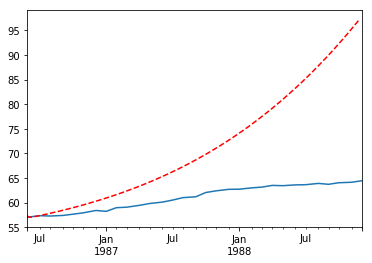

In [173]:
model1 = sm.tsa.SARIMAX(train, order=(best_param[0],1,best_param[1]), trend = [1,1,1,1], freq='W' ).fit(disp=False)
print(model1.summary())
pred = model1.predict(start = '1986-06-01', end='1988-12-01')
r2 = r2_score(test, pred[1:32])
print ('R^2: %1.2f' % r2)
print(metrics.rmse(test,pred[1:32]))
test.plot()
pred.plot(style='r--')

/home/anna/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


R^2: -1.35
3.83532020291


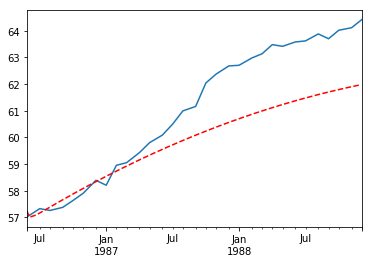

In [123]:
model1 = sm.tsa.SARIMAX(train, order=(2,1,3), trend = [1,1,0,0], freq='W' ).fit()

pred = model1.predict(start = '1986-06-01', end='1988-12-01')
r2 = r2_score(test, pred[1:32])
print ('R^2: %1.2f' % r2)
print(metrics.rmse(test,pred[1:32]))
test.plot()
pred.plot(style='r--')

R^2: -0.37
2.92530073932


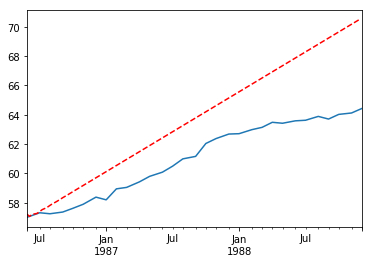

In [132]:
pred = model.predict(start = '1986-06-01', end='1988-12-01', typ = 'levels')
r2 = r2_score(test, pred[1:32])
print ('R^2: %1.2f' % r2)
print(metrics.rmse(pred[1:32], test))
test.plot()
pred.plot(style='r--')

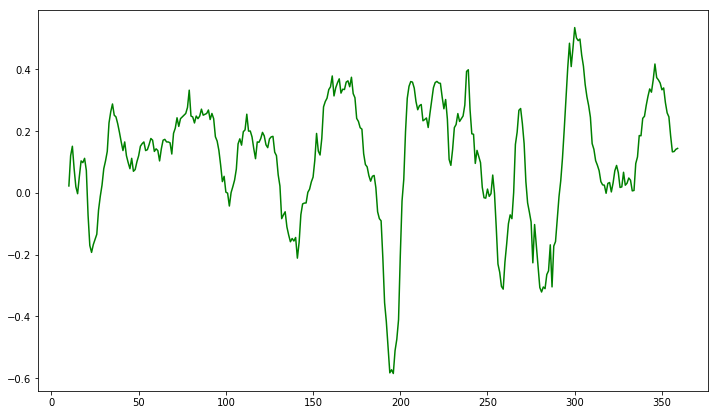

In [60]:
plt.figure(figsize = (12, 7))
rolling_mean1 = df1.rolling(window=10).mean()
plt.plot(rolling_mean1, "g", label="Rolling mean trend")